### Deep Q learning 

100%|█████████████████████████████████████████| 500/500 [15:11<00:00,  1.82s/it]


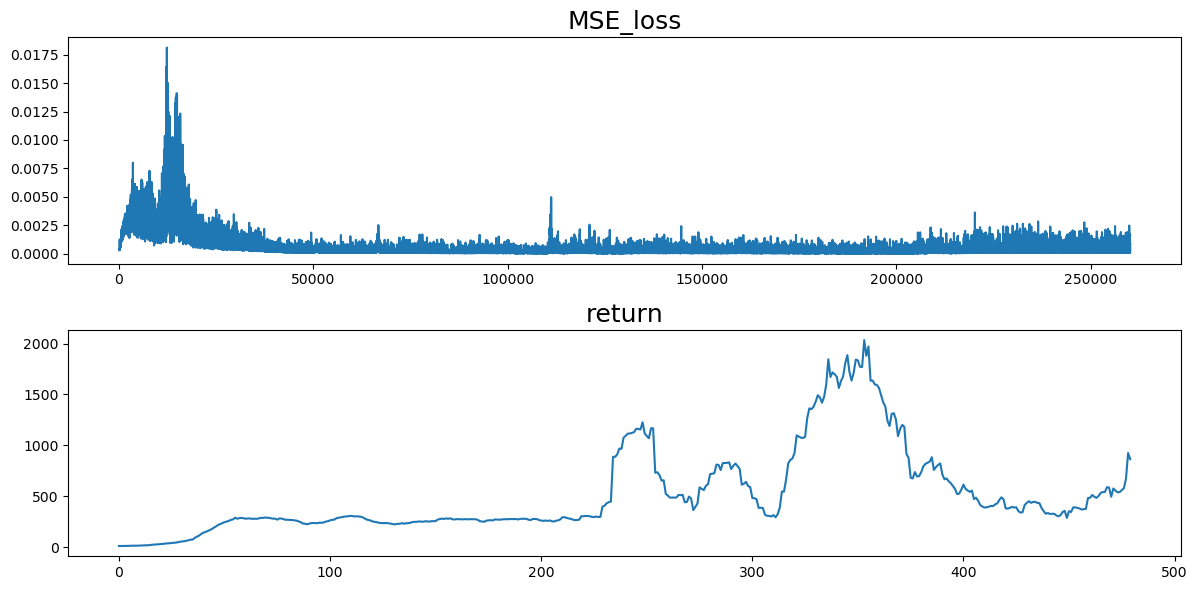

In [2]:
import sys
from typing import Dict, List, Tuple
from tqdm import tqdm
import gym
import collections
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tr import plot_stats




# Q_network
class Q_net(nn.Module):
    def __init__(self, state_space,
                 action_space):
        super(Q_net, self).__init__()

        # space size check
     
        self.Linear1 = nn.Linear(state_space, 64)
        self.Linear2 = nn.Linear(64, 64)
        self.Linear3 = nn.Linear(64, action_space)

    def forward(self, x):
        x = F.relu(self.Linear1(x))
        x = F.relu(self.Linear2(x))
        return self.Linear3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,1)
        else:
            return self.forward(obs).argmax().item()

class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def put(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size


def train_DQN(q_net=None, target_q_net=None, replay_buffer=None,
         
          batch_size=64,
          gamma=0.99,
          learning_rate = 0.0001,
          
          min_buffer_len = 64,
          episodes = 500,
          target_update_period = 10,
          epsilon = 0.2):

    

    # Get batch from replay buffer
    optimizer = optim.Adam(Q.parameters(), lr=learning_rate)
    stats={"MSE_loss":[],"return":[]}
    
    for i in tqdm(range(episodes)):
        state = env.reset()[0]
        done = False
        score = 0
        t=0
        
        while not done:

           
            action = Q.sample_action(torch.from_numpy(state).float(), epsilon)
            
            

            # Do action
            next_state, reward, done, _,_ = env.step(action)
        
            done_mask = 0.0 if done else 1.0

            replay_buffer.put(state, action, reward/100.0, next_state, done_mask)
            
            if len(replay_buffer) >= min_buffer_len:
                
                samples = replay_buffer.sample()
                states = torch.FloatTensor(samples["obs"])
                actions = torch.LongTensor(samples["acts"].reshape(-1,1))
                rewards = torch.FloatTensor(samples["rews"].reshape(-1,1))
                next_states = torch.FloatTensor(samples["next_obs"])
                dones = torch.FloatTensor(samples["done"].reshape(-1,1))

                # Define loss
                q_target_max = target_q_net(next_states).max(1)[0].unsqueeze(1).detach()
                targets = rewards + gamma*q_target_max*dones
                q_out = q_net(states)
               
                q_a = q_out.gather(1, actions)

                # Multiply Importance Sampling weights to loss        
                loss = F.smooth_l1_loss(q_a, targets)

                # Update Network
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                stats["MSE_loss"].append(loss.item())
                                         
                if (t+1) % target_update_period== 0:                  
                         Q_target.load_state_dict(Q.state_dict())     
            t=t+1
            state=next_state
            score+=reward
            
        stats["return"].append(score)
    
    return stats


if __name__ == "__main__":

    env_name = "CartPole-v1"

    # Set gym environment
    env = gym.make(env_name)

    # Create Q functions
    Q = Q_net(state_space=env.observation_space.shape[0], 
              action_space=env.action_space.n)
    Q_target = Q_net(state_space=env.observation_space.shape[0], 
                     action_space=env.action_space.n)

    Q_target.load_state_dict(Q.state_dict())

    # Create Replay buffer
    buffer_len = int(100000)
    batch_size=64
    replay_buffer = ReplayBuffer(env.observation_space.shape[0],
                                            size=buffer_len, batch_size=batch_size)
    
    stats=train_DQN(Q, Q_target, replay_buffer)
    
    plot_stats(stats)



### Test the Agent

In [3]:
done=False
env=gym.make("CartPole-v1", render_mode="human")
t=0
while not done:
    obs=env.reset()[0]
    
    obs=torch.tensor(obs)
    opt_policy = Q(obs).argmax().item()
    next_state, reward, done, _,_ = env.step(opt_policy)
    env.render()
    obs=next_state
    t=t+1
    if t>=250:
        break
env.close()  